In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#basics
import sys,os
sys.path.insert(1, os.path.dirname(os.getcwd()))

#utils
import paths

#main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.precision", 4)
%matplotlib inline

#model Libraries
from sklearn import utils
from sklearn import preprocessing

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

In [3]:
#private modules 
#data
from src.data import make_dataset

#utils
from src.utils import memory_usage

#models
from src.models import train_model
from src.models import evaluation

#validation
from src.validation import metrics
from src.validation import metrics_description

In [4]:
%%time
df_training,features,target = make_dataset.get_data(nrows=5000,
                                                    low_memory=True, 
                                                    dataset="training", 
                                                    feather=True)

low memory activated
Memory usage after optimization is: 3.08 MB
Decreased by 49.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 314 entries, id to target_kazutsugi
dtypes: float16(311), int32(1), object(2)
memory usage: 3.1+ MB
None
CPU times: user 1.61 s, sys: 3.66 s, total: 5.27 s
Wall time: 7.85 s


In [5]:
%%time
df_validation,features,target = make_dataset.get_data(nrows=None,
                                                    low_memory=True, 
                                                    dataset="validation", 
                                                    feather=True)

low memory activated
Memory usage after optimization is: 65.86 MB
Decreased by 49.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106895 entries, 0 to 106894
Columns: 314 entries, id to target_kazutsugi
dtypes: float16(311), int32(1), object(2)
memory usage: 65.4+ MB
None
CPU times: user 7 s, sys: 2.99 s, total: 9.99 s
Wall time: 10.2 s


In [6]:
memory_usage.memory()

Available memory (%): 23.197650909423828


In [5]:
results, res_cv = list(), dict()

In [9]:
lr_param_grid =  {
    'lr__n_jobs' : [-1],

}

#model = XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train the model
reg = LinearRegression()


scorer = make_scorer(mean_squared_error)

result = evaluation.evaluate_model(df_training[features], df_training[target],
                                   LinearRegression(), 'lr',
                                   lr_param_grid, 
                                   scorer, n_iter=1, 
                                   cv_folds=grp, pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

==> Starting K-fold cross validation for lr model, 5000 examples
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


==> Elapsed seconds: 1.486
Best lr model: LinearRegression(n_jobs=-1)
Best lr score (val): 0.135


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished


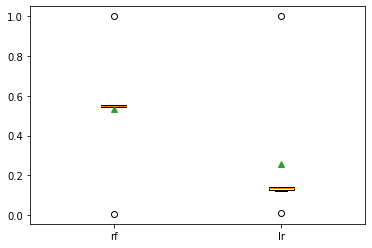

In [10]:
_ = plt.boxplot(res_cv.values(), labels=res_cv.keys(), showmeans=True)

In [11]:
#salvando o pipeline completo
file_path = '../../models/sao_paulo-pipeline.pkl'

model = list(filter(lambda x: x[1] == 'rf', results))[0][0]
model.save(file_path)

In [12]:
#salvando apenas o modelo
from joblib import dump, load
dump(model.model, '../../models/sao_paulo-baseline.pkl')

['../../models/sao_paulo-baseline.pkl']

In [13]:
#carregando o modelo
model_loaded = load(file_path)

### 2a Parte: Metricas

Your submission is scored on the correlation between your predictions and the true targets. The higher the correlation the better.



#### Metricas Submissão:

- Validation Correlation {3.6%..4.4%} (4.8% overfit) (The mean of your per-era correlations)
- Validation Sharpe (per era mean/std)
- Corr With Example Preds (example scripts xgboost)
- Feature Exposure (acima de .08 é mto alto, mas 0.07 é dificil)(example scripts caiu de  .22 para .15 com neutralizacao)


### Metricas Leaderboard (live data):
- Correaltion (spearman??)
- MMC
- Corr W/Metamodel

#### Ranking (média correlation dos ultimos 20 rounds)
- Reputation 
- MMC Rep



#### Métricas Modelo (Classificacao - Multi) (pegar ideias do pycaret)
- AUC {0.515..0.520} (+que isso é overffiting)
- Acuracia
- F1


#### Métricas Modelo (Regressão)
- MSE
- Rˆ2


#### Métricas Modelo (Ranking)
- ????




In [14]:
model = list(filter(lambda x: x[1] == 'rf', results))[0][0]
preds = model.model.predict(model.pipeline.transform(df_validation[features]))

Qtde. eras: 22
performance over time


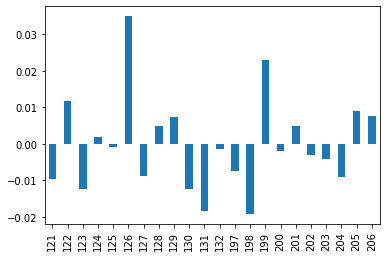

In [58]:
era_scores, era_df, df_metrics, feat_corrs = metrics.submission_metrics(df_validation, preds, model.name)

In [54]:
feat_corrs.describe()

count    310.0000
mean       0.0188
std        0.0317
min       -0.0674
25%       -0.0018
50%        0.0250
75%        0.0422
max        0.0799
dtype: float64

In [59]:
df_metrics

,Valor,Categoria,Range_Aceitavel,Descricao
Metrica,,,,
Model_Name,rf,Submission,NA,Nome do Modelo
Max_Drawdown,-0.0192,Financeira,[0%..2%],Perda máxima em uma era
Avg_corr,-0.0002078,Submission,"[3.6%..4.4%] 4.8%, overfitting",Média spearman corr por era
Median_corr,-0.001808,Estatistica,[3.6%..4.4%] Dentro do range de médias,Mediana spearman corr por era
Variance,0.0001585,Estatistica,[0..] Próximo a zero,Variancia spearman corr por era
Std_Dev,0.01259,Estatistica,[0..] Próximo a zero,Std spearman corr por era
AR(1),-0.2311,Estatistica,[0..] Próximo a zero,"AR(1) das era scores, X = a+ b * X_(-1)"
Skewness,0.9166,Estatistica,[..],Skewness
Exc_Kurtosis,0.8909,Estatistica,[..],Kurtosis


##### Metricas regressao (melhorar para o SP)

In [17]:
model = list(filter(lambda x: x[1] == 'lr', results))[0][0]
preds = model.model.predict(model.pipeline.transform(df_validation[features]))

# Evaluate the model
print('Model performance on validation set:')
score = model.model.score(df_validation[features], df_validation[target])  #default deve ser o R2
mse = mean_squared_error(df_validation[target], preds)
print(f'Training R^2: {score}')
print(f'Training MSE: {mse}')

Model performance on validation set:
Training R^2: -0.10671030742008147
Training MSE: 0.1381569653749466


Qtde. eras: 22
performance over time


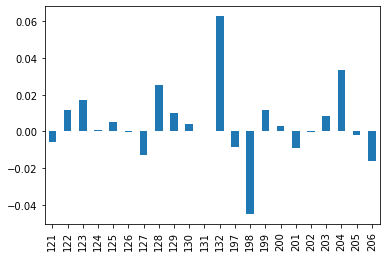

In [18]:
era_scores, era_df, df_metrics = metrics.submission_metrics(df_validation, preds, model.name)

##### Metricas Classificacao (OK)

In [19]:
model = list(filter(lambda x: x[1] == 'rf', results))[0][0]
preds = model.model.predict(model.pipeline.transform(df_validation[features]))
#preds = minmax_scale(preds)

              precision    recall  f1-score   support

           0       0.24      0.30      0.27     21352
           1       0.22      0.23      0.22     21363
           2       0.24      0.25      0.25     21474
           3       0.21      0.19      0.20     21362
           4       0.25      0.19      0.22     21344

    accuracy                           0.23    106895
   macro avg       0.23      0.23      0.23    106895
weighted avg       0.23      0.23      0.23    106895



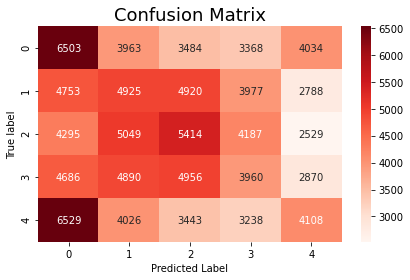

In [20]:
evaluation.plot_confusion_matrix(lab_enc.fit_transform(df_validation[target]), preds)

Rascunho

In [31]:
import pandas as pd
def feature_exposure(df, pred):
    #df = df[df.data_type == 'validation']
    feature_columns = [x for x in df.columns if x.startswith('feature_')]
    correlations = []
    for col in feature_columns:
        correlations.append(np.corrcoef(pred, df[col])[0, 1])
    corr_series = pd.Series(correlations, index=features)
    return corr_series

In [32]:
corrs = feature_exposure(df_validation, preds)

In [34]:
val = {}

val["f_exp"] = corrs.describe()

In [41]:
df_metrics = pd.DataFrame.from_dict(val)
df_metrics




,f_exp
count,310.0000
mean,0.0188
std,0.0317
min,-0.0674
25%,-0.0018
50%,0.0250
75%,0.0422
max,0.0799


In [ ]:
MODEL_FILE = Path("example_model.xgb")

if MODEL_FILE.is_file():
    print("Loading pre-trained model...")
    model.load_model(MODEL_FILE)

In [ ]:
%%time
#from joblib import parallel_backend

#with parallel_backend('threading', n_jobs=-1):
    # Train the model
    #model = RandomForestClassifier(n_estimators=10, n_jobs=-1)
    #model.fit(df_training[features], encoded_target_train)
    # Test the model
    #y_pred = clf.predict(X_test)
